In [1]:

import cv2
import os
import numpy as np
import math
import sys

import matplotlib.pyplot as plt

# Get the current working directory and add the src directory to the sys.path
current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '../src/odometry/')
if src_dir not in sys.path:
    sys.path.append(src_dir)

from readcameramodel import readCameraModel
from undistortimage import undistortImage
from imagepreprocessor import ImagePreprocessor

from constants import *

from utils import *

In [2]:
# Reading dataset:

image_processor = ImagePreprocessor(MODEL_DIR)
image_paths = os.listdir(DATA_DIR)
image_paths.sort()
frame_count = 1
for path in image_paths:
    dst_filename = f'{PROCESSED_DATA_DIR}{str(frame_count).zfill(ZERO_PAD)}.png'
    if os.path.exists(dst_filename):
        frame_count += 1
        continue
    image = cv2.imread((DATA_DIR + path), 0)
    processed_img = image_processor.process_image(image)
    cv2.imwrite(dst_filename, processed_img)
    frame_count += 1
    
    # Initial images are oversaturated, it is ok
    # Plot the original image
    # plt.subplot(1, 2, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title('Original Image')

    # # Plot the processed image
    # plt.subplot(1, 2, 2)
    # plt.imshow(processed_img, cmap='gray')
    # plt.title('Processed Image')

    # # Display the plot
    # plt.show()
    
    # break
print('Done!!')

Done!!


In [3]:
print(frame_count)

3874


## Visual odometry BUILTIN2

In [4]:
from motionestimator import *

use_cached_features = False
use_cached_poses = False

init_point = np.array([0, 0, 0, 1])
H = np.eye(4)
t = np.array([0, 0, 0]).reshape(3,1)
R = np.eye(3)
camera_pose = np.eye(4)

ESTIMATION_METHOD = 'INBUILT_POSE_SELF'
start = time.perf_counter()

K = image_processor.intrinsic_camrera_matrix

features = None
if use_cached_features:
    features = load_features()
pre_calc_poses = None
if use_cached_poses:
    pre_calc_poses = load_poses()

In [5]:
frame_count = 0

In [6]:
frame1_name = str(INIT_IMAGE + frame_count)
frame2_name = str(INIT_IMAGE + frame_count + 1)
frame1 = read_image(INIT_IMAGE + frame_count)
frame2 = read_image(INIT_IMAGE + frame_count + 1)

if (frame1 is None) or (frame2 is None) or (cv2.waitKey(1) == 27):
    throw('Error reading images')

frame_name = str(INIT_IMAGE + frame_count)

pose = None
if pre_calc_poses is not None:
    pose = pre_calc_poses.get(frame_name)
    if pose is not None:
        pose = np.asarray(pose)
        new_R = pose[:, :COL4]
        new_t = pose[:, COL4].reshape(3,1)


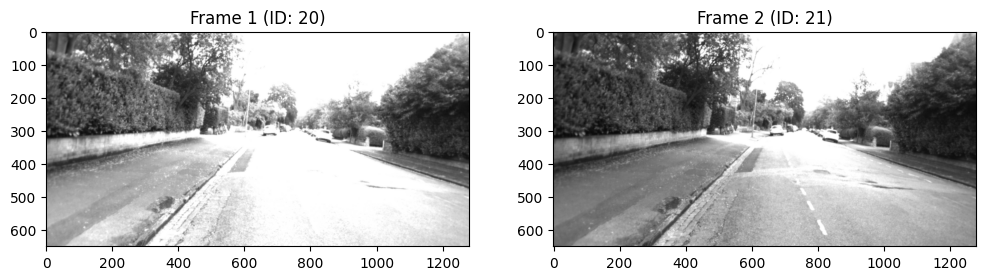

In [7]:
display_plot = True
if display_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increase the size of the figure

    axes[0].imshow(frame1, cmap='gray')
    axes[0].set_title(f'Frame 1 (ID: {frame1_name})')  # Add the ID of the image to the title

    axes[1].imshow(frame2, cmap='gray')
    axes[1].set_title(f'Frame 2 (ID: {frame2_name})')  # Add the ID of the image to the title

    plt.show()


In [8]:
def get_cached_features(features_cache, frame_name):
    features1 = features_cache.get(frame_name).get('features1')
    features2 = features_cache.get(frame_name).get('features2')
    
    features1 = np.array(features1)
    features2 = np.array(features2)

    # TODO: check if those has to be of identical length, feels like a bug
    ind1 = np.where(features1[:, 1] > CROP_MIN)
    features1 = features1[ind1]
    features2 = features2[ind1] # TODO: feels like a bug

    ind2 = np.where(features2[:, 1] > CROP_MIN)
    features1 = features1[ind2]
    features2 = features2[ind2]

    features1[:, 1] = features1[:, 1] - CROP_MIN
    features2[:, 1] = features2[:, 1] - CROP_MIN

    features1 = np.ascontiguousarray(features1)
    features2 = np.ascontiguousarray(features2)
    return features1, features2

In [9]:
def compute_features(frame1, frame2, frame_name, frame2_name, features_cache):
    features1 = []
    features2 = []

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    if features_cache is not None:
        if frame_name in features_cache:
            keypoint1, descriptor1 = features_cache.get(frame_name)
            keypoint2, descriptor2 = sift.detectAndCompute(frame2, mask=None)
            features_cache[frame2_name] = (keypoint2, descriptor2)
        else:
            keypoint1, descriptor1 = sift.detectAndCompute(frame1, mask=None)
            keypoint2, descriptor2 = sift.detectAndCompute(frame2, mask=None)
            features_cache[frame2_name] = (keypoint2, descriptor2)
    else:
        keypoint1, descriptor1 = sift.detectAndCompute(frame1, mask=None)
        keypoint2, descriptor2 = sift.detectAndCompute(frame2, mask=None)
    

    # Draw keypoints on the image
    # Display the image with keypoints
    detailed_vis = False
    if detailed_vis:
        image_with_keypoints = cv2.drawKeypoints(frame1, keypoint1, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        cv2.imshow('SIFT Keypoints', image_with_keypoints)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # FLANN parameters
    # FLANN_INDEX_KDTREE = 1 # Original
    FLANN_INDEX_KDTREE = 0
    # index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) # Original
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=1)
    # search_params = dict(checks=50)  # Original
    search_params = dict(checks=5)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # matches = flann.knnMatch(descriptor1, descriptor2, k=2) # Original
    matches = flann.knnMatch(descriptor1, descriptor2, k=1)
    
    # Classical 2-matches approach
    # ratio test as per Lowe's paper
    # good_matches = []
    # for i, (top1, top2) in enumerate(matches):
    #     if top1.distance < 0.8*top2.distance:
    #     # if top1.distance < 1.0*top2.distance: # === for the intentionally bad filtering
    #         x1, y1 = keypoint1[top1.queryIdx].pt
    #         x2, y2 = keypoint2[top1.trainIdx].pt
    #         features1.append([x1, y1, 1])
    #         features2.append([x2, y2, 1])
    #         good_matches.append(top1)

    good_matches = []
    for top1 in matches:
        # if top1.distance < 0.8*top2.distance:
        # if top1.distance < 1.0*top2.distance: # === for the intentionally bad filtering
        x1, y1 = keypoint1[top1[0].queryIdx].pt
        x2, y2 = keypoint2[top1[0].trainIdx].pt
        features1.append([x1, y1, 1])
        features2.append([x2, y2, 1])
            

    display_matches = False
    if display_matches:
        image_matches = cv2.drawMatches(frame1, keypoint1,
                                        frame2, keypoint2,
                                        good_matches,
                                        outImg=None, 
                                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Display the image with matches
        cv2.imshow('Matches', image_matches)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # write_to_file(features1, features2, frame_name)

    features1 = np.ascontiguousarray(features1)
    features2 = np.ascontiguousarray(features2)

    return features1, features2

In [10]:

# Check the number of threads OpenCV is using
num_threads = cv2.getNumThreads()
print(f"Number of threads OpenCV is using: {num_threads}")


Number of threads OpenCV is using: 16


In [11]:

# Generate random descriptors for benchmarking
descriptor1 = np.random.rand(10000, 128).astype(np.float32)
descriptor2 = np.random.rand(10000, 128).astype(np.float32)

# Function to perform FLANN matching
def flann_matcher(descriptor1, descriptor2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=1)
    search_params = dict(checks=5)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptor1, descriptor2, k=1)
    return matches

# Benchmark with different numbers of threads
for num_threads in [1, 2, 4, 8, 16]:
    cv2.setNumThreads(num_threads)
    start_time = time.time()
    flann_matcher(descriptor1, descriptor2)
    end_time = time.time()
    print(f"Time taken with {num_threads} threads: {end_time - start_time:.4f} seconds")



Time taken with 1 threads: 0.0478 seconds
Time taken with 2 threads: 0.0365 seconds
Time taken with 4 threads: 0.0336 seconds
Time taken with 8 threads: 0.0347 seconds
Time taken with 16 threads: 0.0381 seconds


In [12]:
features_cache = features
# if features_cache is not None and  frame_name in features_cache:
#     features1, features2 = get_cached_features(features_cache, frame_name)
# else:
features1, features2 = compute_features(frame1, frame2, frame_name,  frame_name, features_cache = None)

In [13]:
import timeit

# Full trajectory pipeline:

In [31]:
from motionestimator import *
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Function to combine two images side by side
def combine_images(image1, image2):
    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]
    combined_height = max(height1, height2)
    combined_width = width1 + width2

    combined_image = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)
    combined_image[:height1, :width1, :3] = image1
    combined_image[:height2, width1:width1+width2, :3] = image2

    return combined_image

def plot_route(x_coords, z_coords):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(x_coords, -np.array(z_coords), color='r')
    ax.set_xlim(-10, 200)  # Adjust limits as needed
    ax.set_ylim(-10, 200)  # Adjust limits as needed
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Convert canvas to image
    img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return img

In [15]:
pre_calc_poses = None

In [41]:

def run():
    global pre_calc_poses
    cached = False
    K = image_processor.intrinsic_camrera_matrix

    features = dict()
    if use_cached_features:
        features = load_features()
    poses = None
    if use_cached_poses:
        pre_calc_poses = load_poses()

    init_point = np.array([0, 0, 0, 1])
    H = np.eye(4)
    t = np.array([0, 0, 0]).reshape(3,1)
    R = np.eye(3)
    camera_pose = np.eye(4)

    use_openCV_pose = True
    ESTIMATION_METHOD = 'INBUILT_POSE_SELF'
    if use_openCV_pose:
        ESTIMATION_METHOD = 'INBUILT'

    start = time.perf_counter()

    x_coords = []
    z_coords = []

    frame2 = read_image(INIT_IMAGE)

    step = 3
    for frame_count in tqdm(range(0, STOP_IMAGE - INIT_IMAGE + 1, step)):
        frame1 = frame2.copy()
        frame2 = read_image(INIT_IMAGE + frame_count + step)

        if (frame1 is None) or (frame2 is None) or (cv2.waitKey(1) == 27):
            break
        
        frame_name = str(INIT_IMAGE + frame_count)
        frame2_name = str(INIT_IMAGE + frame_count + step)

        pose = None
        if pre_calc_poses is not None:        
            pose = pre_calc_poses.get(frame_name)
            if pose is not None:
                pose = np.asarray(pose)
                new_R = pose[:, :COL4]
                new_t = pose[:, COL4].reshape(3,1)

        # if cache is not available:
        if pose is None:
            pre_calc_poses = dict()
            # if features_cache is not None and features_cache.get(frame_name) is not None:
            #     features1, features2 = get_cached_features(features_cache, frame_name)
            # else:
                # if cached == False:
                #     cached = True
            features1, features2 = compute_features(frame1, frame2, frame_name, frame2_name, features_cache)

            if use_openCV_pose:
                essential_mat, _ = cv2.findEssentialMat(features1[:, :COL3],
                                                        features2[:, :COL3],
                                                        focal=K[ROW1, COL1], 
                                                        pp=(K[ROW1, COL3], K[ROW2, COL3]), 
                                                        method=cv2.RANSAC,
                                                        prob=0.999, threshold=0.5)
                _, new_R, new_t, mask = cv2.recoverPose(essential_mat, features1[:, :COL3], features2[:, :COL3], K)
                if np.linalg.det(new_R) < 0:
                    new_R = -new_R
                    new_t = -new_t
                pre_calc_poses[frame_name] = list(np.column_stack((new_R, new_t)))
                        
            else:
                fundamental_matrix, point_list1, point_list2 = fundmntl_mat_from_8_point_ransac(features1, features2)
                essential_mat = calc_essential_matrix(K, fundamental_matrix)
                poses = get_possible_camera_poses(essential_mat)
                pose = get_correct_pose(poses, point_list1, point_list2, non_linear_flag=False)
                new_R = pose[:, :COL4]
                new_t = pose[:, COL4].reshape(3,1)
                pre_calc_poses[frame_name] = list(pose)

            with open(POSE_FILE, 'w') as pose_file:
                json.dump(pre_calc_poses, pose_file, cls=NumpyArrayEncoder)
                
        new_pose = np.column_stack((new_R, new_t))
        new_pose = np.vstack((new_pose, np.array([0,0,0,1])))

        camera_pose = camera_pose @ new_pose

        x_coord = camera_pose[0, -1]
        z_coord = camera_pose[2, -1]
        x_coords.append(x_coord)
        z_coords.append(z_coord)

        # x_coord = camera_pose[ROW1, -1]
        # z_coord = camera_pose[ROW3, -1]
        # x_coords.append(x_coord)
        # z_coords.append(z_coord)

        # print('\n\nframe_count', frame_count, frame_name)
        # print('\n\nTime taken: ', (time.perf_counter() - start))

        # plt.scatter(x_coords, -np.array(z_coords), color='r') 
        # plt.pause(0.00001)
        # plt.savefig(PLOT_FILE_PATH.format(ESTIMATION_METHOD, frame_name.zfill(ZERO_PAD)), bbox_inches='tight')
        
        # frm = cv2.resize(frame1, (0,0), fx=0.5, fy=0.5)
        # cv2.imshow('Frame ', frm)


        if frame_count % 12 == 0:
            # print(f'Frame count: {frame_count}')
            # print(f'x_coord: {x_coord}, z_coord: {z_coord}')
            # print(f'Camera pose: {camera_pose}')

            # Plot current route and convert to image
            route_image = plot_route(x_coords, z_coords)
            route_image = cv2.resize(route_image, (frame1.shape[1] // 2, frame1.shape[0] // 2))
            frame1_resized = cv2.resize(frame1, (frame1.shape[1] // 2, frame1.shape[0] // 2))
            combined_image = combine_images(frame1_resized, route_image)
            cv2.imshow('Combined View', combined_image)

            cv2.imwrite(f'combined_image_{frame_count}.png', combined_image)

        
        # Break the loop on key press (for example, 'q')
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # if frame_count == 20:
        #     break

    cv2.imwrite('combined_image.png', combined_image)
    cv2.destroyAllWindows()
    plt.show()

In [39]:
%load_ext line_profiler
%reload_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [42]:
run()

100%|██████████| 61/61 [00:41<00:00,  1.48it/s]


In [43]:
%lprun -f run  run()

 28%|██▊       | 17/61 [00:13<00:34,  1.27it/s]


Timer unit: 1e-09 s

Total time: 13.3974 s
File: /tmp/ipykernel_62823/1817582357.py
Function: run at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run():
     2                                               global pre_calc_poses
     3         1        806.0    806.0      0.0      cached = False
     4         1       1727.0   1727.0      0.0      K = image_processor.intrinsic_camrera_matrix
     5                                           
     6         1        551.0    551.0      0.0      features = dict()
     7         1        319.0    319.0      0.0      if use_cached_features:
     8                                                   features = load_features()
     9         1        155.0    155.0      0.0      poses = None
    10         1        224.0    224.0      0.0      if use_cached_poses:
    11                                                   pre_calc_poses = load_poses()
    12            

In [24]:
%lprun -f fundmntl_mat_from_8_point_ransac fundmntl_mat_from_8_point_ransac(features1, features2)

Timer unit: 1e-09 s

Total time: 3.44742 s
File: /home/dkushn/projects/research_frontiers_2024/notebooks/../src/odometry/utils.py
Function: fundmntl_mat_from_8_point_ransac at line 33

Line #      Hits         Time  Per Hit   % Time  Line Contents
    33                                           def fundmntl_mat_from_8_point_ransac(point_list1, point_list2):
    34         1        944.0    944.0      0.0      fundamental_mat_model = FundamentalMatrixModel()
    35         1       2280.0   2280.0      0.0      ransac_model = Ransac(fundamental_mat_model)
    36                                           
    37         1     510566.0 510566.0      0.0      total_data = np.column_stack((point_list1, point_list2))
    38         1 3446907213.0    3e+09    100.0      fundamental_mat, point_list1, point_list2 = ransac_model.fit(total_data, N_POINT, RANSAC_THRESH)
    39         1        259.0    259.0      0.0      return fundamental_mat, point_list1, point_list2

In [20]:
features_cache = dict()

In [23]:
%lprun -f compute_features  compute_features(frame1, frame2, frame_name, frame2_name, features_cache)

Timer unit: 1e-09 s

Total time: 0.847939 s
File: /tmp/ipykernel_62823/574242906.py
Function: compute_features at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def compute_features(frame1, frame2, frame_name, frame2_name, features_cache):
     2         1        415.0    415.0      0.0      features1 = []
     3         1        168.0    168.0      0.0      features2 = []
     4                                           
     5                                               # Initiate SIFT detector
     6         1       7375.0   7375.0      0.0      sift = cv2.SIFT_create()
     7                                           
     8                                               # find the keypoints and descriptors with SIFT
     9         1        241.0    241.0      0.0      if features_cache is not None:
    10         1        469.0    469.0      0.0          if frame_name in features_cache:
    11         1     

In [29]:
%lprun -f run run()

 11%|█         | 20/181 [00:02<00:16,  9.68it/s]


Timer unit: 1e-09 s

Total time: 2.06794 s
File: /tmp/ipykernel_59660/2194246613.py
Function: run at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run():
     2                                               global pre_calc_poses
     3         1        846.0    846.0      0.0      cached = False
     4         1       1511.0   1511.0      0.0      K = image_processor.intrinsic_camrera_matrix
     5                                           
     6         1        172.0    172.0      0.0      features = None
     7         1        386.0    386.0      0.0      if use_cached_features:
     8                                                   features = load_features()
     9         1        186.0    186.0      0.0      poses = None
    10         1        261.0    261.0      0.0      if use_cached_poses:
    11                                                   pre_calc_poses = load_poses()
    12              

In [21]:
# Sample data for testing
x_coords = [0, 1, 2, 3]
z_coords = [0, 1, 4, 9]

%lprun -f plot_route plot_route(x_coords, z_coords)

Timer unit: 1e-09 s

Total time: 0.0778563 s
File: /tmp/ipykernel_59660/2948893975.py
Function: plot_route at line 18

Line #      Hits         Time  Per Hit   % Time  Line Contents
    18                                           def plot_route(x_coords, z_coords):
    19         1   26213174.0    3e+07     33.7      fig, ax = plt.subplots(figsize=(5, 5))
    20         1     742847.0 742847.0      1.0      ax.plot(x_coords, -np.array(z_coords), color='r')
    21         1     800771.0 800771.0      1.0      ax.set_xlim(-1, 100)  # Adjust limits as needed
    22         1      97749.0  97749.0      0.1      ax.set_ylim(-1, 100)  # Adjust limits as needed
    23         1      14668.0  14668.0      0.0      canvas = FigureCanvas(fig)
    24         1   46441337.0    5e+07     59.7      canvas.draw()
    25                                           
    26                                               # Convert canvas to image
    27         1    3469378.0    3e+06      4.5      img = n